In [1]:
from os import environ

from pyspark.sql import SparkSession

environ[
    'PYSPARK_PYTHON'] = "/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/venv/bin/python"
session = SparkSession.builder \
    .master("yarn") \
    .appName("web-archive-query-log-query-length") \
    .config("spark.executor.instances", 3) \
    .getOrCreate()

In [2]:
sc = session.sparkContext
sc

<SparkContext master=yarn appName=web-archive-query-log-query-length>

In [3]:
stop_words = [
    # "茅聵驴茅聡聦猫聹聵猫聸聸忙卤",
    # "é\x98¿é\x87\x8cè\x9c\x98è\x9b\x9bæ±",
]

In [4]:
from pathlib import Path

global_data_dir = Path("/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/")
global_data_dir

PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log')

In [5]:
data_dir = global_data_dir / "focused"
data_dir

PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/focused')

In [6]:
from pathlib import Path

figures_dir = Path("figures")
figures_dir.mkdir(parents=True, exist_ok=True)

In [7]:
def paths_jsonl(service: str, base_type: str):
    base_path = data_dir / base_type / service
    if not base_path.exists():
        return []
    yield from base_path.glob("*/*.jsonl.gz")

In [34]:
from json import loads, JSONDecodeError
from typing import Iterator
from gzip import GzipFile

def read_jsonl(path: Path) -> Iterator:
    print(f"Read JSONL records in {path}.")
    try:
        with GzipFile(path, "r") as gzip_file:
            for line in gzip_file:
                try:
                    url = loads(line)
                except JSONDecodeError:
                    continue
                yield url
    except:
        raise
        return 

In [35]:
from typing import Optional


def detect_language(text: str) -> Optional[str]:
    text = text.replace("\n", " ")
    # if len(text) < 10:
    #     return None
    from cld3 import get_language
    language_prediction = get_language(text)
    if language_prediction is None:
        return None
    return language_prediction.language.split("-")[0] if language_prediction.is_reliable else None

In [85]:
def group_key(service_query: tuple) -> tuple:
    service, query = service_query
    query_text = query["query"]
    language = detect_language(query_text)
    return service, language, len(query_text)

In [86]:
with Path("services.txt").open("rt") as file:
    alexa_services = [
        line.strip()
        for line in file
        if line
    ]
len(alexa_services)

1087

In [87]:
from json import loads
from pandas import DataFrame
from datetime import datetime

counts = sc.parallelize(alexa_services, 1000)\
    .keyBy(lambda service: service)\
    .flatMapValues(lambda service: paths_jsonl(service, "archived-query-urls"))\
    .repartition(10_000)\
    .flatMapValues(read_jsonl)\
    .keyBy(group_key)\
    .countByKey()

In [88]:
len(counts)

450647

In [90]:
df = DataFrame([
    {
        "service": service,
        "language": language,
        "query_length": query_length,
        "count": count,
    }
    for (service, language, query_length), count in counts.items()
])
df

,service,language,query_length,count
0,wikimedia,en,32,654
1,wikimedia,None,9,3665
2,wikimedia,None,13,6724
3,wikimedia,it,26,67
4,wikimedia,sv,12,155
...,...,...,...,...
450642,wikimedia,ceb,46,1
450643,wikimedia,bs,1,1
450644,wikimedia,da,55,2
450645,wikimedia,sq,5,1


In [150]:
top_services = df.groupby("service")["count"].sum().sort_values(ascending=False).head(5).index
#     "google",
#     "youtube",
#     "baidu",
#     "qq",
#     "facebook",
#     # "yahoo",
#     # "amazon",
#     # "wikimedia",
#     # "jd",
#     # "360",
# ]
top_services

Index(['google', 'baidu', 'twitter', 'youtube', 'stackoverflow'], dtype='object', name='service')

In [151]:
top_languages = df.groupby("language")["count"].sum().sort_values(ascending=False).head(5).index
top_languages

Index(['zh', 'en', 'ga', 'ja', 'ru'], dtype='object', name='language')

In [152]:
service_names = {
    "google": "Google",
    "youtube": "YouTube",
    "baidu": "Baidu",
    "qq": "QQ",
    "facebook": "Facebook",
    "twitter": "Twitter",
    "stackoverflow": "StackOverflow",
}

In [153]:
df_plot = df.copy()
df_plot = df_plot[df_plot["service"].isin(top_services)]
# df_plot.loc[
#     ~df_plot["service"].isin(top_services),
#     "service",
# ] = "other"
# df_plot.loc[
#     ~df_plot["language"].isin(top_languages),
#     "language",
# ] = "other"
df_plot["service"] = df_plot["service"].map(service_names)
top_services = [service_names.get(service, None) for service in top_services]
df_plot = df_plot.groupby([
    "service", 
    # "language", 
    "query_length",
])["count"].sum().reset_index()
df_plot

,service,query_length,count
0,Baidu,0,90
1,Baidu,1,9723
2,Baidu,2,1213140
3,Baidu,3,1398569
4,Baidu,4,2066450
...,...,...,...
3601,YouTube,3386,1
3602,YouTube,4699,3
3603,YouTube,5105,1
3604,YouTube,5636,1


<Figure size 640x480 with 0 Axes>

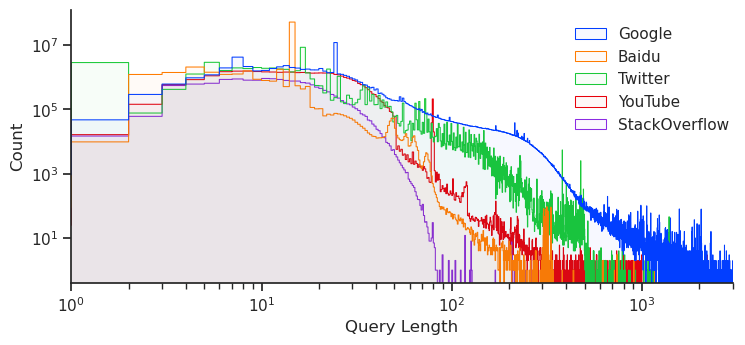

In [162]:
from seaborn import histplot, FacetGrid, color_palette, kdeplot, displot, set_theme, set_style, move_legend
from matplotlib.pyplot import tight_layout, axhline

width = 7.5
aspect = 2
set_theme()
tight_layout()
set_style("ticks")
plot = displot(
    data=df_plot,
    kind="hist",
    x="query_length",
    weights="count",
    # hue="language",
    # hue_order=[*top_languages, "other"],
    hue="service",
    hue_order=[*top_services],
    palette="bright",
    element="step",
    # element="poly",
    # multiple="stack",
    # alpha=0.5,
    linewidth=0.75,
    alpha=0.03,
    binwidth=1,
    aspect=aspect,
    height=width/aspect,
    # linewidth=0,
)
plot.set(
    xlim=(1, 3000),
)
plot.set_axis_labels("Query Length", "Count")
# plot.set_axis_labels("", "")
move_legend(
    plot,
    title="",
    loc="upper right",
    bbox_to_anchor=(0.8, 0.9),
)
plot.set(
    yscale="log", 
    xscale="log",
)
# plot.despine(left=True)
plot.savefig("figures/plot-query-length-histogram.pdf")
plot.savefig("figures/plot-query-length-histogram.png")
plot